# Insert packages

In [101]:
# data analysis stack
import pandas as pd
import numpy as np


# data visualization stack
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# machine learning stack
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# miscellaneous
import warnings
warnings.filterwarnings("ignore")




# Load data

In [2]:
df = pd.read_csv('ECA_blended_custom/TG_STAID002759.txt',skiprows=19, index_col=1, parse_dates=True)
df

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0
...,...,...,...
2022-06-26,111448,263,0
2022-06-27,111448,281,0
2022-06-28,111448,214,0


# Data Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53507 entries, 1876-01-01 to 2022-06-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0    SOUID  53507 non-null  int64
 1      TG   53507 non-null  int64
 2    Q_TG   53507 non-null  int64
dtypes: int64(3)
memory usage: 1.6 MB


In [4]:
df.head(20)

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0
1876-01-06,127488,-77,0
1876-01-07,127488,-66,0
1876-01-08,127488,-89,0
1876-01-09,127488,-127,0


# Clean the data

### Column names

In [5]:
df.columns

Index([' SOUID', '   TG', ' Q_TG'], dtype='object')

We notice some white spaces in the column names. Let's clean this.

In [6]:
df.columns = df.columns.str.strip()
df.columns

Index(['SOUID', 'TG', 'Q_TG'], dtype='object')

### Temperature values

The units of the values in the temperature column are in 0.1 °C. For easier interpretation, let's convert them to 1 °C 

In [7]:
# Divide the values in the TG column by 10

df['TG'] = df['TG']/10
df.head()

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,2.2,0
1876-01-02,127488,2.5,0
1876-01-03,127488,0.3,0
1876-01-04,127488,-5.8,0
1876-01-05,127488,-9.8,0


### Check missing values

According to the original txt file, a 9 in the Q_TG column indicates missing data for the corresponding day.
Therefore, we can apply a filter to the Q_TG column to see how many missing values there are.

In [8]:
missing_values = df[df['Q_TG']==9]
missing_values.index 

DatetimeIndex(['1945-04-25', '1945-04-26', '1945-04-27', '1945-04-28',
               '1945-04-29', '1945-04-30', '1945-05-01', '1945-05-02',
               '1945-05-03', '1945-05-04',
               ...
               '1945-10-27', '1945-10-28', '1945-10-29', '1945-10-30',
               '1945-10-31', '1945-11-01', '1945-11-02', '1945-11-03',
               '1945-11-04', '1945-11-05'],
              dtype='datetime64[ns]', name='    DATE', length=195, freq=None)

The 195 missing values are the days between 25-04-1945 and 05-11-1945.

### Data imputation

To impute the missing values, I decide to take the mean temperatures from 2 years before and two years after:

In [9]:
before = df.loc['1943-04-25':'1945-04-24']
after = df.loc['1945-11-06':'1947-11-05']

before = before.groupby([before.index.month, before.index.day]).mean()
after = after.groupby([after.index.month, after.index.day]).mean()


In [10]:
for date in missing_values.index:
    df.loc[date,'TG'] = round((before.loc[(date.month,date.day),'TG']+ 
                              after.loc[(date.month,date.day),'TG'])/2,1)

### Dropping unnecessary columns

In [11]:
df.drop(['SOUID', 'Q_TG'], axis=1, inplace=True)

### Rename TG column

In [12]:
df.rename({'TG':'temperature'}, axis=1, inplace=True)

In [13]:
df.columns

Index(['temperature'], dtype='object')

# Plot the data

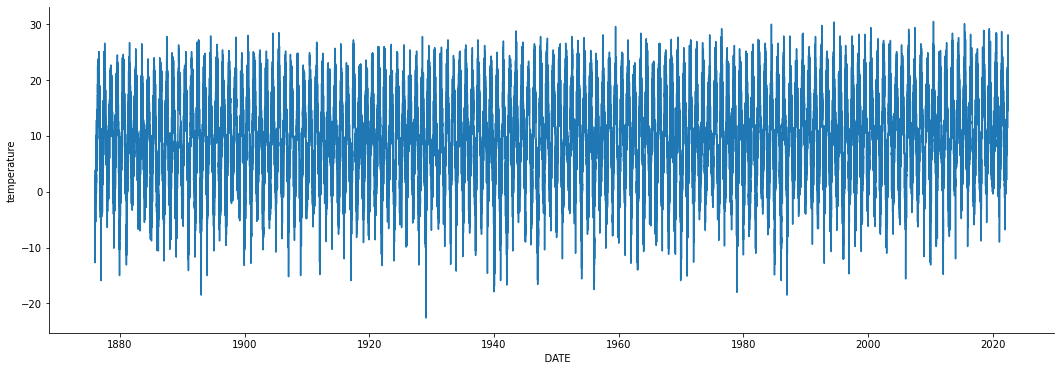

In [14]:
plt.figure(figsize=(18,6))
sns.lineplot(x=df.index, y=df['temperature'])
sns.despine()

# Train-test split

In [15]:
df_train = df[:-365]

df_test = df[-365:]

# Model trend

In [16]:
# Create a timestep variable

df_train['timestep'] = list(range(df_train.shape[0]))
df_train.head()

,temperature,timestep
DATE,,
1876-01-01,2.2,0
1876-01-02,2.5,1
1876-01-03,0.3,2
1876-01-04,-5.8,3
1876-01-05,-9.8,4


In [17]:
# Feature and target for trend model

X_trend = df_train[['timestep']]
y_trend = df_train['temperature']

In [18]:
# Fit a linear function of the timestep to data

trend_model = LinearRegression()

trend_model.fit(X_trend, y_trend)

LinearRegression()

In [19]:
# predict from fitted model

df_train['trend'] = trend_model.predict(X_trend)
df_train

,temperature,timestep,trend
DATE,,,
1876-01-01,2.2,0,8.541287
1876-01-02,2.5,1,8.541319
1876-01-03,0.3,2,8.541352
1876-01-04,-5.8,3,8.541385
1876-01-05,-9.8,4,8.541417
...,...,...,...
2021-06-26,21.5,53137,10.273889
2021-06-27,22.1,53138,10.273921
2021-06-28,25.3,53139,10.273954


**Plot trend and original data**

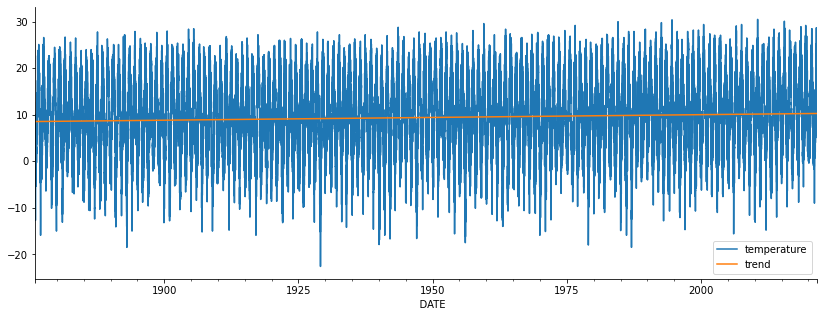

In [20]:
df_train[['temperature','trend']].plot(figsize=(14,5),legend=True)
sns.despine()

# Model seasonality

In [21]:
# subtract trend from data

df_train['detrended'] = df_train['temperature'] - df_train['trend']

In [22]:
# create month column

df_train['month'] = df_train.index.month

In [23]:
# make dummy columns for months

seasonal_dummies = pd.get_dummies(
    df_train.index.month, 
    prefix='month', 
    drop_first=True
).set_index(df_train.index)

In [24]:
# add dummy columns to our dataframe


df_train = df_train.join(seasonal_dummies)

#df_train = pd.concat([df_train, seasonal_dummies], axis=1)

In [25]:
df_train.columns

Index(['temperature', 'timestep', 'trend', 'detrended', 'month', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [26]:
df_train.head()

,temperature,timestep,trend,detrended,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,,
1876-01-01,2.2,0,8.541287,-6.341287,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,2.5,1,8.541319,-6.041319,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,0.3,2,8.541352,-8.241352,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,-5.8,3,8.541385,-14.341385,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,-9.8,4,8.541417,-18.341417,1,0,0,0,0,0,0,0,0,0,0,0


In [27]:
df_train = df_train.drop(columns='month', axis=1)
df_train

,temperature,timestep,trend,detrended,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,
1876-01-01,2.2,0,8.541287,-6.341287,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,2.5,1,8.541319,-6.041319,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,0.3,2,8.541352,-8.241352,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,-5.8,3,8.541385,-14.341385,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,-9.8,4,8.541417,-18.341417,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,21.5,53137,10.273889,11.226111,0,0,0,0,1,0,0,0,0,0,0
2021-06-27,22.1,53138,10.273921,11.826079,0,0,0,0,1,0,0,0,0,0,0
2021-06-28,25.3,53139,10.273954,15.026046,0,0,0,0,1,0,0,0,0,0,0


In [28]:
# feature and target for seasonality model

X_seasonality = df_train[df_train.columns[-11:]]
y_seasonality = df_train['detrended']

In [29]:
# fit seasonality model

seasonality_model = LinearRegression()
seasonality_model.fit(X_seasonality, y_seasonality)

LinearRegression()

In [30]:
# predict from fitted model

df_train['seasonality'] = seasonality_model.predict(X_seasonality)

**Plot seasonality and detrended data**

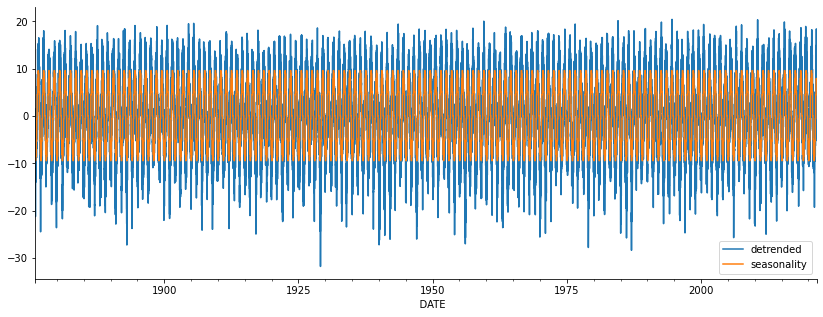

In [31]:
df_train[['detrended','seasonality']].plot(figsize=(14,5),legend=True)
sns.despine()

**Plot trend + seasonality and original data**

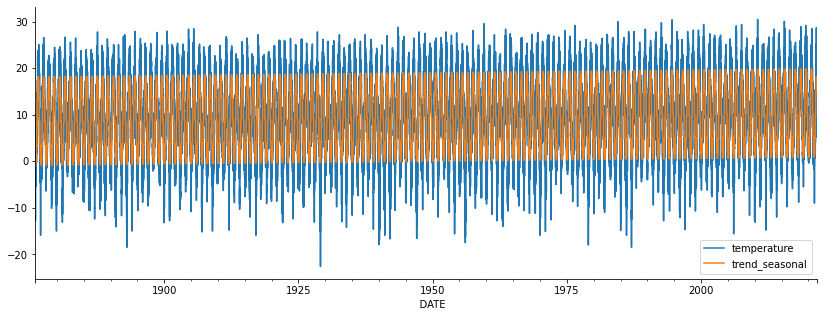

In [32]:
# combine trend and seasonality

df_train['trend_seasonal'] = df_train['trend'] + df_train['seasonality']

df_train[['temperature','trend_seasonal']].plot(figsize=(14,5),legend=True)
sns.despine()

## Extract Remainder

In [33]:
# leftover time series devoid of trend and seasonality

df_train['remainder'] = df_train['temperature'] - df_train['trend_seasonal']

### Plot remainder

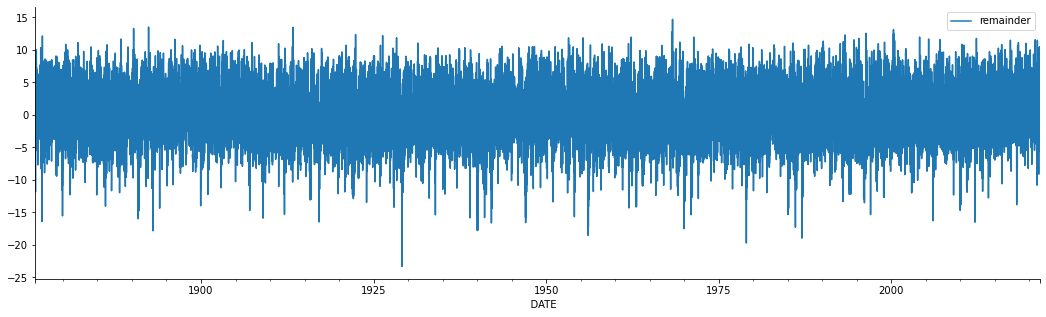

In [34]:
df_train['remainder'].plot(figsize=(18,5),legend=True)
sns.despine()

## Decomposition with `statsmodel`

In [35]:
#!pip install statsmodels

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

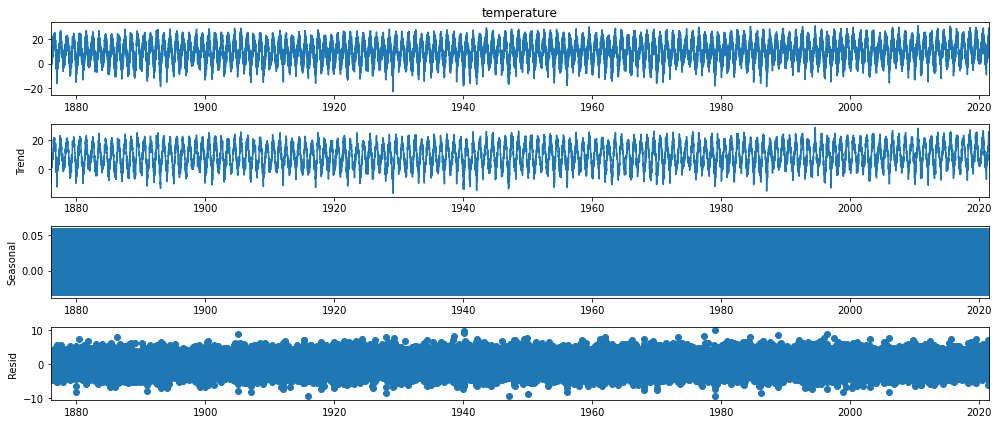

In [37]:
sd = seasonal_decompose(df_train['temperature'], model='additive')

plt.rcParams['figure.figsize'] = (14,6)
sd.plot()
None

In [38]:
df_train["remainder"].mean(), df_train["remainder"].std(), df_train["temperature"].std()

(-1.2060320418042423e-15, 3.926981977682919, 7.877761033473614)

# Inspect the remainder to decide how many lags to include

In [39]:
from statsmodels.tsa.ar_model import ar_select_order

selected_order = ar_select_order(df_train['remainder'], maxlag = 12)
selected_order.ar_lags

[1, 2, 3, 4]

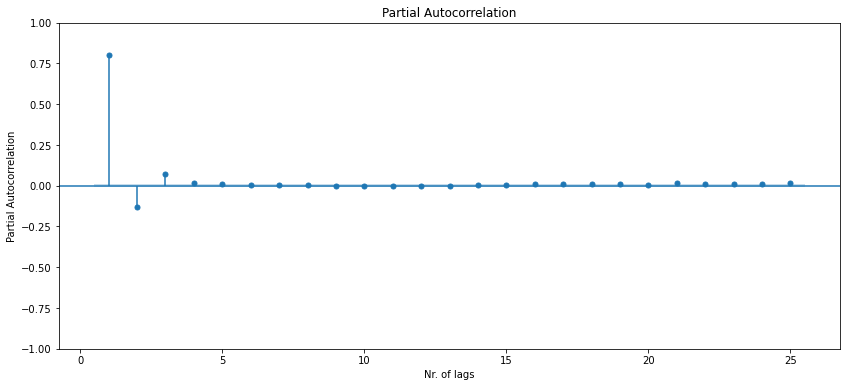

In [103]:
# plot partial autocorrelation function

plot_pacf(df_train['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation')
None

## Add the lags of the remainder to the training data

In [40]:
df_train['lag1'] = df_train['remainder'].shift(1)
df_train['lag2'] = df_train['remainder'].shift(2)
df_train['lag3'] = df_train['remainder'].shift(3)
df_train['lag4'] = df_train['remainder'].shift(4)
df_train.dropna(inplace=True)
df_train.head()

,temperature,timestep,trend,detrended,month_2,month_3,month_4,month_5,month_6,month_7,...,month_10,month_11,month_12,seasonality,trend_seasonal,remainder,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-05,-9.8,4,8.541417,-18.341417,0,0,0,0,0,0,...,0,0,0,-9.411273,-0.869856,-8.930144,-4.930112,1.169921,3.369953,3.069986
1876-01-06,-7.7,5,8.541450,-16.241450,0,0,0,0,0,0,...,0,0,0,-9.411273,-0.869823,-6.830177,-8.930144,-4.930112,1.169921,3.369953
1876-01-07,-6.6,6,8.541483,-15.141483,0,0,0,0,0,0,...,0,0,0,-9.411273,-0.869790,-5.730210,-6.830177,-8.930144,-4.930112,1.169921
1876-01-08,-8.9,7,8.541515,-17.441515,0,0,0,0,0,0,...,0,0,0,-9.411273,-0.869758,-8.030242,-5.730210,-6.830177,-8.930144,-4.930112
1876-01-09,-12.7,8,8.541548,-21.241548,0,0,0,0,0,0,...,0,0,0,-9.411273,-0.869725,-11.830275,-8.030242,-5.730210,-6.830177,-8.930144


# Model the Trend_Seasonal model

In [41]:
# Define X and y
X = df_train.drop(columns=['temperature', 'trend', 'detrended', 'seasonality', 'trend_seasonal', 'remainder', 'lag1', 'lag2', 'lag3', 'lag4'])
y = df_train['temperature']

In [42]:
X

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0
1876-01-06,5,0,0,0,0,0,0,0,0,0,0,0
1876-01-07,6,0,0,0,0,0,0,0,0,0,0,0
1876-01-08,7,0,0,0,0,0,0,0,0,0,0,0
1876-01-09,8,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,53137,0,0,0,0,1,0,0,0,0,0,0
2021-06-27,53138,0,0,0,0,1,0,0,0,0,0,0
2021-06-28,53139,0,0,0,0,1,0,0,0,0,0,0


In [43]:
y

    DATE
1876-01-05    -9.8
1876-01-06    -7.7
1876-01-07    -6.6
1876-01-08    -8.9
1876-01-09   -12.7
              ... 
2021-06-26    21.5
2021-06-27    22.1
2021-06-28    25.3
2021-06-29    24.1
2021-06-30    18.2
Name: temperature, Length: 53138, dtype: float64

In [44]:
# Create and fit the model
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [45]:
# Create a new column with the predictions of the trend_seasonal model
df_train['trend_seasonal'] = m.predict(X)
df_train.head()

,temperature,timestep,trend,detrended,month_2,month_3,month_4,month_5,month_6,month_7,...,month_10,month_11,month_12,seasonality,trend_seasonal,remainder,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-05,-9.8,4,8.541417,-18.341417,0,0,0,0,0,0,...,0,0,0,-9.411273,-0.871875,-8.930144,-4.930112,1.169921,3.369953,3.069986
1876-01-06,-7.7,5,8.541450,-16.241450,0,0,0,0,0,0,...,0,0,0,-9.411273,-0.871842,-6.830177,-8.930144,-4.930112,1.169921,3.369953
1876-01-07,-6.6,6,8.541483,-15.141483,0,0,0,0,0,0,...,0,0,0,-9.411273,-0.871809,-5.730210,-6.830177,-8.930144,-4.930112,1.169921
1876-01-08,-8.9,7,8.541515,-17.441515,0,0,0,0,0,0,...,0,0,0,-9.411273,-0.871777,-8.030242,-5.730210,-6.830177,-8.930144,-4.930112
1876-01-09,-12.7,8,8.541548,-21.241548,0,0,0,0,0,0,...,0,0,0,-9.411273,-0.871744,-11.830275,-8.030242,-5.730210,-6.830177,-8.930144


# Run the full model

In [46]:
# Assign X
X_full = df_train.drop(columns=['temperature', 'trend_seasonal', 'trend', 'detrended', 'remainder', 'seasonality'])
y_full = df_train['temperature']

In [47]:
X_full.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0,-4.930112,1.169921,3.369953,3.069986
1876-01-06,5,0,0,0,0,0,0,0,0,0,0,0,-8.930144,-4.930112,1.169921,3.369953
1876-01-07,6,0,0,0,0,0,0,0,0,0,0,0,-6.830177,-8.930144,-4.930112,1.169921
1876-01-08,7,0,0,0,0,0,0,0,0,0,0,0,-5.730210,-6.830177,-8.930144,-4.930112
1876-01-09,8,0,0,0,0,0,0,0,0,0,0,0,-8.030242,-5.730210,-6.830177,-8.930144


In [48]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [49]:
# Create a new predictions column
df_train['predictions_full_model'] = m_full.predict(X_full)

In [50]:
df_train.tail()

,temperature,timestep,trend,detrended,month_2,month_3,month_4,month_5,month_6,month_7,...,month_11,month_12,seasonality,trend_seasonal,remainder,lag1,lag2,lag3,lag4,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,,
2021-06-26,21.5,53137,10.273889,11.226111,0,0,0,0,1,0,...,0,0,7.923701,18.199015,3.302411,2.202443,-0.697524,-0.697492,0.602541,20.292398
2021-06-27,22.1,53138,10.273921,11.826079,0,0,0,0,1,0,...,0,0,7.923701,18.199047,3.902378,3.302411,2.202443,-0.697524,-0.697492,20.720942
2021-06-28,25.3,53139,10.273954,15.026046,0,0,0,0,1,0,...,0,0,7.923701,18.199080,7.102345,3.902378,3.302411,2.202443,-0.697524,21.218198
2021-06-29,24.1,53140,10.273987,13.826013,0,0,0,0,1,0,...,0,0,7.923701,18.199113,5.902313,7.102345,3.902378,3.302411,2.202443,24.151503
2021-06-30,18.2,53141,10.274019,7.925981,0,0,0,0,1,0,...,0,0,7.923701,18.199145,0.002280,5.902313,7.102345,3.902378,3.302411,22.481012


# Plot the prediction vs temperature for the training data

<AxesSubplot:xlabel='    DATE'>

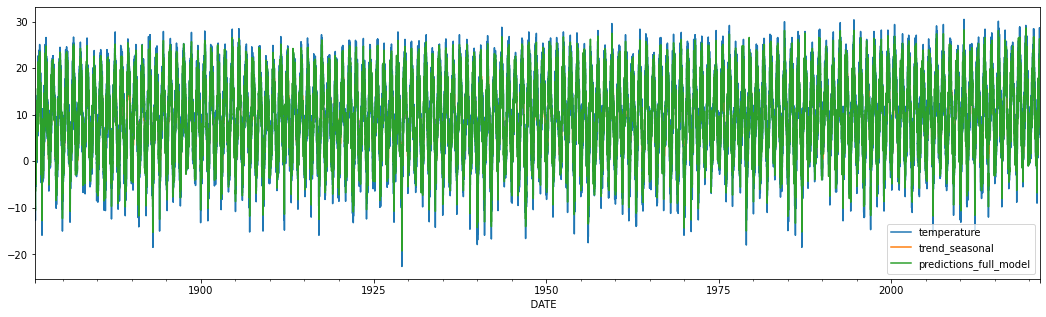

In [51]:
df_train[['temperature', 'trend_seasonal', 'predictions_full_model']].plot(figsize=(18,5))

Coefficients of the AR equation's terms:

In [52]:
pd.DataFrame(m_full.coef_.reshape(1,16), columns=X_full.columns)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
0,0.000033,0.958912,4.187725,8.827256,13.913126,17.270612,18.979803,18.214158,14.460451,9.445852,4.561599,1.347935,0.919034,-0.193365,0.054666,0.016647


# Evaluate the model
## Cross-validation

We want to understand how good our model would work on data it has not been trained on. We can get an estimate of that by using cross-validation:

Dividing training data into subsets (folds).
In the first iteration, use the first fold to evaluate the second fold.
In the second iteration, use the first and the second fold to evaluate the third fold. Etc.

In [53]:
X_full

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0,-4.930112,1.169921,3.369953,3.069986
1876-01-06,5,0,0,0,0,0,0,0,0,0,0,0,-8.930144,-4.930112,1.169921,3.369953
1876-01-07,6,0,0,0,0,0,0,0,0,0,0,0,-6.830177,-8.930144,-4.930112,1.169921
1876-01-08,7,0,0,0,0,0,0,0,0,0,0,0,-5.730210,-6.830177,-8.930144,-4.930112
1876-01-09,8,0,0,0,0,0,0,0,0,0,0,0,-8.030242,-5.730210,-6.830177,-8.930144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,53137,0,0,0,0,1,0,0,0,0,0,0,2.202443,-0.697524,-0.697492,0.602541
2021-06-27,53138,0,0,0,0,1,0,0,0,0,0,0,3.302411,2.202443,-0.697524,-0.697492
2021-06-28,53139,0,0,0,0,1,0,0,0,0,0,0,3.902378,3.302411,2.202443,-0.697524


In [54]:
X_full.shape

(53138, 16)

In [55]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [56]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print('\n')
    

The training data for the 1th iteration are the observations steps 
    [   0    1    2 ... 8855 8856 8857]
The validation data for the 1th iteration are the observations steps
    [ 8858  8859  8860 ... 17711 17712 17713]


The training data for the 2th iteration are the observations steps 
    [    0     1     2 ... 17711 17712 17713]
The validation data for the 2th iteration are the observations steps
    [17714 17715 17716 ... 26567 26568 26569]


The training data for the 3th iteration are the observations steps 
    [    0     1     2 ... 26567 26568 26569]
The validation data for the 3th iteration are the observations steps
    [26570 26571 26572 ... 35423 35424 35425]


The training data for the 4th iteration are the observations steps 
    [    0     1     2 ... 35423 35424 35425]
The validation data for the 4th iteration are the observations steps
    [35426 35427 35428 ... 44279 44280 44281]


The training data for the 5th iteration are the observations steps 
    [    0    

In [57]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full) 

In [58]:
# Do the cross validation: Remember these are the 'test scores' in the training data.
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.90481362, 0.91363198, 0.91356197, 0.90899007, 0.91791546])

In [59]:
result.mean()

0.9117826178955444

The mean is relatively high and the variance low

## Augmented Dickey-Fuller Test

In [60]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""adf_stats: {adf_stats}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            CI 99%: {levels['1%']}
            CI 95%: {levels['5%']}
            CI 90%: {levels['10%']}
            information criterion (AIC): {information_criterion}
            """)

In [61]:
print_adf(df_train['remainder'])

adf_stats: -23.748254806590886
            p: 0.0 
            used lag: 58 
            number of observations: 53079
            CI 99%: -3.4304732053406015
            CI 95%: -2.861594454299857
            CI 90%: -2.5667989842107257
            information criterion (AIC): 239328.36354688782
            


--> the remainder is stationary! We can reject the 0-hypothesis with a probability of 99%, since -23.75 < -3.43. So I can model with ARIMA, etc.

# Testing the model

We finally use test data

In [62]:
df_test.head()

,temperature
DATE,
2021-07-01,15.7
2021-07-02,19.9
2021-07-03,20.3
2021-07-04,22.5
2021-07-05,20.5


First, the transformations necessary for the trend-seasonal model test:

We will need to define the timestep using the last timestep of the training data (unless you split after adding the timestep and dummies).

In [63]:
# Get last timestep of the training data
last_train_timestep = df_train['timestep'][-1]

In [64]:
# Create a timestep for the whole test data
df_test['timestep'] = list(range(last_train_timestep + 1, 
                            last_train_timestep + len(df_test) + 1))
df_test.head()

,temperature,timestep
DATE,,
2021-07-01,15.7,53142
2021-07-02,19.9,53143
2021-07-03,20.3,53144
2021-07-04,22.5,53145
2021-07-05,20.5,53146


Now let's create the dummies for the seasonal component of the test.

In [65]:
seasonal_dummies = pd.get_dummies(df_test.index.month, 
                                  prefix='month', 
                                  drop_first=True).set_index(df_test.index)

df_test = df_test.join(seasonal_dummies)
df_test.head()

,temperature,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
2021-07-01,15.7,53142,0,0,0,0,0,1,0,0,0,0,0
2021-07-02,19.9,53143,0,0,0,0,0,1,0,0,0,0,0
2021-07-03,20.3,53144,0,0,0,0,0,1,0,0,0,0,0
2021-07-04,22.5,53145,0,0,0,0,0,1,0,0,0,0,0
2021-07-05,20.5,53146,0,0,0,0,0,1,0,0,0,0,0


Let's select X and y.

In [66]:
X_test = df_test.drop(columns=['temperature'])

In [67]:
X_test

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,
2021-07-01,53142,0,0,0,0,0,1,0,0,0,0,0
2021-07-02,53143,0,0,0,0,0,1,0,0,0,0,0
2021-07-03,53144,0,0,0,0,0,1,0,0,0,0,0
2021-07-04,53145,0,0,0,0,0,1,0,0,0,0,0
2021-07-05,53146,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,53502,0,0,0,0,1,0,0,0,0,0,0
2022-06-27,53503,0,0,0,0,1,0,0,0,0,0,0
2022-06-28,53504,0,0,0,0,1,0,0,0,0,0,0


Predict trend and seasonality for the test using m (which is trend_seasonal model for the training).

In [68]:
df_test['trend_seasonal'] = m.predict(X_test)
df_test.head()

,temperature,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
DATE,,,,,,,,,,,,,,
2021-07-01,15.7,53142,0,0,0,0,0,1,0,0,0,0,0,19.886062
2021-07-02,19.9,53143,0,0,0,0,0,1,0,0,0,0,0,19.886095
2021-07-03,20.3,53144,0,0,0,0,0,1,0,0,0,0,0,19.886128
2021-07-04,22.5,53145,0,0,0,0,0,1,0,0,0,0,0,19.886160
2021-07-05,20.5,53146,0,0,0,0,0,1,0,0,0,0,0,19.886193


<AxesSubplot:xlabel='    DATE'>

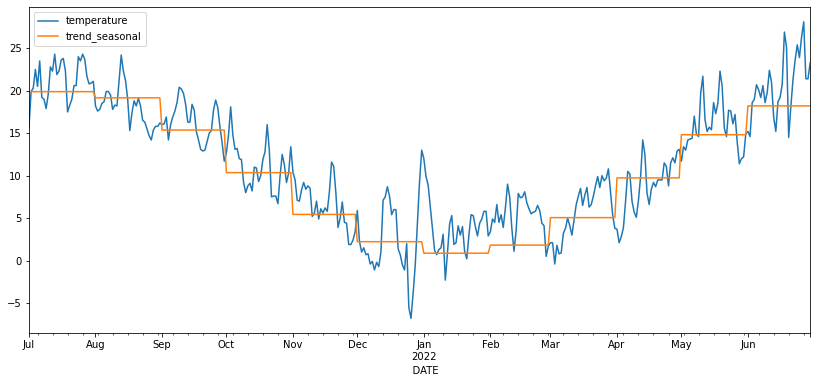

In [69]:
df_test[['temperature', 'trend_seasonal']].plot()

Calculate the remainder for the test set.

In [70]:
df_test['remainder'] = df_test['temperature'] - df_test['trend_seasonal']

And finally the lag for the remainder as our additional feature for the AR model.

In [71]:
# Create the lagged variable
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)
df_test['lag4'] = df_test['remainder'].shift(4)

In [72]:
df_test.head()

,temperature,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,,,,
2021-07-01,15.7,53142,0,0,0,0,0,1,0,0,0,0,0,19.886062,-4.186062,NaN,NaN,NaN,NaN
2021-07-02,19.9,53143,0,0,0,0,0,1,0,0,0,0,0,19.886095,0.013905,-4.186062,NaN,NaN,NaN
2021-07-03,20.3,53144,0,0,0,0,0,1,0,0,0,0,0,19.886128,0.413872,0.013905,-4.186062,NaN,NaN
2021-07-04,22.5,53145,0,0,0,0,0,1,0,0,0,0,0,19.886160,2.613840,0.413872,0.013905,-4.186062,NaN
2021-07-05,20.5,53146,0,0,0,0,0,1,0,0,0,0,0,19.886193,0.613807,2.613840,0.413872,0.013905,-4.186062


In [73]:
# Assign X_full
X_full = df_test.drop(columns=['temperature', 'trend_seasonal', 'remainder'])

In [74]:
X_full.head() # Contains a NaN for the first value of lag1

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,
2021-07-01,53142,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN
2021-07-02,53143,0,0,0,0,0,1,0,0,0,0,0,-4.186062,NaN,NaN,NaN
2021-07-03,53144,0,0,0,0,0,1,0,0,0,0,0,0.013905,-4.186062,NaN,NaN
2021-07-04,53145,0,0,0,0,0,1,0,0,0,0,0,0.413872,0.013905,-4.186062,NaN
2021-07-05,53146,0,0,0,0,0,1,0,0,0,0,0,2.613840,0.413872,0.013905,-4.186062


Now we need to fill the NaN values

In [75]:
X_full.loc['2021-07-01', 'lag1'] = df_train.loc['2021-06-30', 'remainder']
X_full.loc['2021-07-01', 'lag2'] = df_train.loc['2021-06-29', 'remainder']
X_full.loc['2021-07-01', 'lag3'] = df_train.loc['2021-06-28', 'remainder']
X_full.loc['2021-07-01', 'lag4'] = df_train.loc['2021-06-27', 'remainder']
X_full.loc['2021-07-02', 'lag2'] = df_train.loc['2021-06-30', 'remainder']
X_full.loc['2021-07-02', 'lag3'] = df_train.loc['2021-06-29', 'remainder']
X_full.loc['2021-07-02', 'lag4'] = df_train.loc['2021-06-28', 'remainder']
X_full.loc['2021-07-03', 'lag3'] = df_train.loc['2021-06-30', 'remainder']
X_full.loc['2021-07-03', 'lag4'] = df_train.loc['2021-06-29', 'remainder']
X_full.loc['2021-07-04', 'lag4'] = df_train.loc['2021-06-30', 'remainder']

In [76]:
X_full.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,
2021-07-01,53142,0,0,0,0,0,1,0,0,0,0,0,0.002280,5.902313,7.102345,3.902378
2021-07-02,53143,0,0,0,0,0,1,0,0,0,0,0,-4.186062,0.002280,5.902313,7.102345
2021-07-03,53144,0,0,0,0,0,1,0,0,0,0,0,0.013905,-4.186062,0.002280,5.902313
2021-07-04,53145,0,0,0,0,0,1,0,0,0,0,0,0.413872,0.013905,-4.186062,0.002280
2021-07-05,53146,0,0,0,0,0,1,0,0,0,0,0,2.613840,0.413872,0.013905,-4.186062


In [77]:
# Create the predictions
df_test['predictions_full_model'] = m_full.predict(X_full)

<AxesSubplot:xlabel='    DATE'>

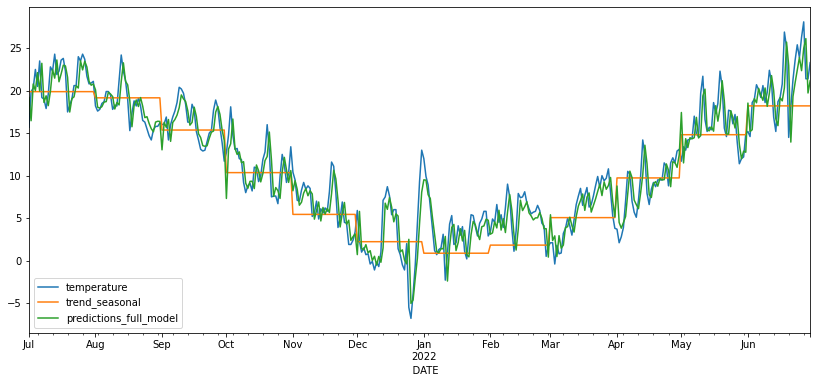

In [78]:
df_test[['temperature', 'trend_seasonal', 'predictions_full_model']].plot()

In [79]:
# Create the complete dataset and plot it
df_full = df_train[['temperature', 'trend_seasonal', 'predictions_full_model']].append(df_test[['temperature', 'trend_seasonal', 'predictions_full_model']])

In [80]:
df_full.head()

,temperature,trend_seasonal,predictions_full_model
DATE,,,
1876-01-05,-9.8,-0.871875,-5.363564
1876-01-06,-7.7,-0.871842,-7.975436
1876-01-07,-6.6,-0.871809,-5.642083
1876-01-08,-8.9,-0.871777,-5.357417
1876-01-09,-12.7,-0.871744,-7.635679


<AxesSubplot:xlabel='    DATE'>

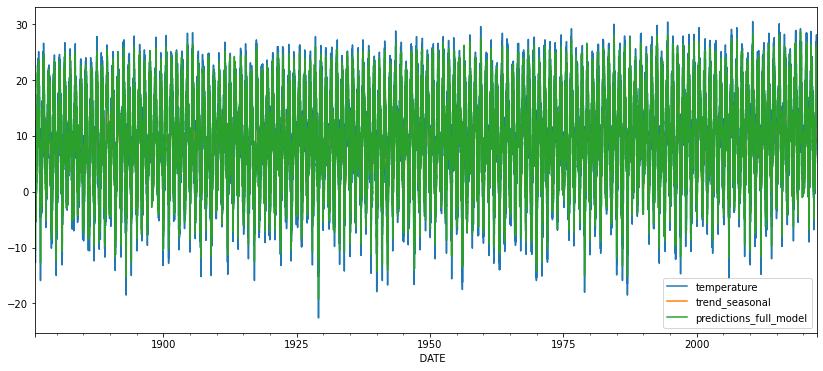

In [81]:
df_full.plot()

In [82]:
X_test.head(1)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,
2021-07-01,53142,0,0,0,0,0,1,0,0,0,0,0


In [83]:
print(f"""
{m_full.score(X_full, df_test['temperature'])}
{m.score(X_test, df_test['temperature'])}
""")



0.9166204721990029
0.7800774507944238



# Predict the future

So far we have just predicted data that we already had (train and test). We have not actually made any predictions for the future.


In [84]:
df_test.head()

,temperature,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,lag4,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,
2021-07-01,15.7,53142,0,0,0,0,0,1,0,0,0,0,0,19.886062,-4.186062,NaN,NaN,NaN,NaN,19.184867
2021-07-02,19.9,53143,0,0,0,0,0,1,0,0,0,0,0,19.886095,0.013905,-4.186062,NaN,NaN,NaN,16.464201
2021-07-03,20.3,53144,0,0,0,0,0,1,0,0,0,0,0,19.886128,0.413872,0.013905,-4.186062,NaN,NaN,20.791517
2021-07-04,22.5,53145,0,0,0,0,0,1,0,0,0,0,0,19.886160,2.613840,0.413872,0.013905,-4.186062,NaN,20.019829
2021-07-05,20.5,53146,0,0,0,0,0,1,0,0,0,0,0,19.886193,0.613807,2.613840,0.413872,0.013905,-4.186062,22.124238


In [85]:
# Combine train and test data
df_combined = df_train.append(df_test)
df_combined.head()

,temperature,timestep,trend,detrended,month_2,month_3,month_4,month_5,month_6,month_7,...,month_11,month_12,seasonality,trend_seasonal,remainder,lag1,lag2,lag3,lag4,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-05,-9.8,4,8.541417,-18.341417,0,0,0,0,0,0,...,0,0,-9.411273,-0.871875,-8.930144,-4.930112,1.169921,3.369953,3.069986,-5.363564
1876-01-06,-7.7,5,8.541450,-16.241450,0,0,0,0,0,0,...,0,0,-9.411273,-0.871842,-6.830177,-8.930144,-4.930112,1.169921,3.369953,-7.975436
1876-01-07,-6.6,6,8.541483,-15.141483,0,0,0,0,0,0,...,0,0,-9.411273,-0.871809,-5.730210,-6.830177,-8.930144,-4.930112,1.169921,-5.642083
1876-01-08,-8.9,7,8.541515,-17.441515,0,0,0,0,0,0,...,0,0,-9.411273,-0.871777,-8.030242,-5.730210,-6.830177,-8.930144,-4.930112,-5.357417
1876-01-09,-12.7,8,8.541548,-21.241548,0,0,0,0,0,0,...,0,0,-9.411273,-0.871744,-11.830275,-8.030242,-5.730210,-6.830177,-8.930144,-7.635679


In [86]:
# Re-train the model on the whole dataset
X_combined = df_combined.drop(columns=['temperature', 'trend', 'detrended', 'seasonality',  'trend_seasonal', 'remainder', 'predictions_full_model'])
y_combined = df_combined['temperature']

In [87]:
X_combined.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0,-4.930112,1.169921,3.369953,3.069986
1876-01-06,5,0,0,0,0,0,0,0,0,0,0,0,-8.930144,-4.930112,1.169921,3.369953
1876-01-07,6,0,0,0,0,0,0,0,0,0,0,0,-6.830177,-8.930144,-4.930112,1.169921
1876-01-08,7,0,0,0,0,0,0,0,0,0,0,0,-5.730210,-6.830177,-8.930144,-4.930112
1876-01-09,8,0,0,0,0,0,0,0,0,0,0,0,-8.030242,-5.730210,-6.830177,-8.930144


Fill in the missing value from the beginning of the test set.

In [88]:
X_combined.loc['2021-07-01', 'lag1'] = df_train.loc['2021-06-30', 'remainder']
X_combined.loc['2021-07-01', 'lag2'] = df_train.loc['2021-06-29', 'remainder']
X_combined.loc['2021-07-01', 'lag3'] = df_train.loc['2021-06-28', 'remainder']
X_combined.loc['2021-07-01', 'lag4'] = df_train.loc['2021-06-27', 'remainder']
X_combined.loc['2021-07-02', 'lag2'] = df_train.loc['2021-06-30', 'remainder']
X_combined.loc['2021-07-02', 'lag3'] = df_train.loc['2021-06-29', 'remainder']
X_combined.loc['2021-07-02', 'lag4'] = df_train.loc['2021-06-28', 'remainder']
X_combined.loc['2021-07-03', 'lag3'] = df_train.loc['2021-06-30', 'remainder']
X_combined.loc['2021-07-03', 'lag4'] = df_train.loc['2021-06-29', 'remainder']
X_combined.loc['2021-07-04', 'lag4'] = df_train.loc['2021-06-30', 'remainder']


In [89]:
X_combined.loc['2021-07-01':'2021-07-04']

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,
2021-07-01,53142,0,0,0,0,0,1,0,0,0,0,0,0.002280,5.902313,7.102345,3.902378
2021-07-02,53143,0,0,0,0,0,1,0,0,0,0,0,-4.186062,0.002280,5.902313,7.102345
2021-07-03,53144,0,0,0,0,0,1,0,0,0,0,0,0.013905,-4.186062,0.002280,5.902313
2021-07-04,53145,0,0,0,0,0,1,0,0,0,0,0,0.413872,0.013905,-4.186062,0.002280


In [90]:
X_combined.tail()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,
2022-06-26,53502,0,0,0,0,1,0,0,0,0,0,0,5.689097,7.189130,5.389162,3.089195
2022-06-27,53503,0,0,0,0,1,0,0,0,0,0,0,8.089064,5.689097,7.189130,5.389162
2022-06-28,53504,0,0,0,0,1,0,0,0,0,0,0,9.889032,8.089064,5.689097,7.189130
2022-06-29,53505,0,0,0,0,1,0,0,0,0,0,0,3.188999,9.889032,8.089064,5.689097
2022-06-30,53506,0,0,0,0,1,0,0,0,0,0,0,3.188966,3.188999,9.889032,8.089064


In [91]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

### We are going to create a single future step data.


In [92]:
# What is the first date in the future? --> 2022-07-01
timestep = df_combined['timestep'].max() + 1

months = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
lag1 = df_combined.loc['2022-06-30', 'remainder']
lag2 = df_combined.loc['2022-06-29', 'remainder']
lag3 = df_combined.loc['2022-06-28', 'remainder']
lag4 = df_combined.loc['2022-06-27', 'remainder']

In [93]:
timestep, months, lag1, lag2, lag3, lag4

(53507,
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 5.08893364928824,
 3.1889663094103895,
 3.188998969532534,
 9.889031629654689)

In [94]:
X_future = [timestep]

X_future

[53507]

In [95]:
X_future.extend(months)
X_future

[53507, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

Check what would have happened above if you had used append instead of extend.

In [96]:
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)
X_future.append(lag4)

X_future

[53507,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 5.08893364928824,
 3.1889663094103895,
 3.188998969532534,
 9.889031629654689]

In [97]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
0,53507,0,0,0,0,0,1,0,0,0,0,0,5.088934,3.188966,3.188999,9.889032


In [98]:
# Prediction for 2022-07-01
# m_full.predict(X_future) is somehow a better idea.
m_combined.predict(X_future)

array([24.28780857])

**The predicted temperature is 24.29°**


In [2]:
#y_forecast, ci = m.predict(365, return_conf_int=True)

In [ ]:
#y_forecast

In [106]:
#!pip install pmdarima

In [107]:
#import pmdarima as pm

In [112]:
#remainder_model = pm.auto_arima(
#    df_train['remainder'],
#    start_p=0,
#    max_p=2,
#    seasonality = False,
#    stationarity = True,
#    trace = True,
#    n_jobs=-1
#)

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=244333.183, Time=3.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=246406.435, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=246382.818, Time=0.89 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=246369.423, Time=2.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=246404.435, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=25.81 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=242977.915, Time=5.53 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=38.73 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=242089.726, Time=8.77 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=46.66 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=241335.442, Time=15.11 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=56.34 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=241333.445, Time=8.49 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=242087.728, Time=4.99 sec
 ARIMA(1,1,5)(0,0,0)[0]     

In [1]:
# Checking assumptions of AR model
#data['temp'].rolling(window=365).mean()
#data['temp'].rolling(window=365).std()
